## Problem 1:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from knn import knnClassifier

### let's check what's in the columns

In [2]:
df_train = pd.read_csv('train.csv')
df_train.columns

Index(['LABEL', 'SENSOR_A', 'SENSOR_B', 'TIME', 'container_id'], dtype='object')

### let's check out the distribution of the sensors

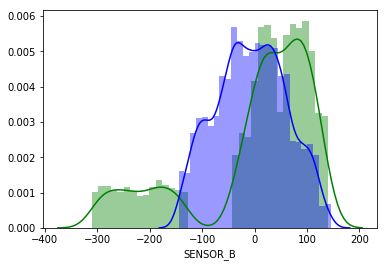

In [3]:
sns.distplot(df_train['SENSOR_A'], color='g')
sns.distplot(df_train['SENSOR_B'], color='b');

### now lets plot them together

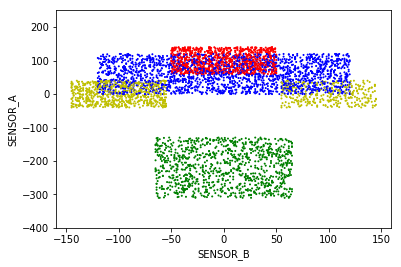

In [4]:
var = 'SENSOR_B'
color_dic = {"NOISE": 'b', "UNLOAD_SHIP": 'g', "LOAD_TRAIN": 'r', "DEPART_TRAIN": 'y'}
colors_0 = [color_dic[a] for a in df_train["LABEL"]]
data = pd.concat([df_train['SENSOR_A'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SENSOR_A', s=1, c=colors_0, ylim=(-400, 250));

so the result is very interesting
- we can see that it is not a real life dataset
- we can see that the noise (in blue) overlaps two other categories. So this is going to be a difficult problem in terms of predictions
- the ultimate goal is to label the data by taking into account the fact that each label should appear once and only once for each container. So it would be better to have a model that gives us a score rather than a label. Indeed, we want to be able to choose the sequence of events that is the most likely. We can see that there are two overlapping areas blue vs yellow ('depart' vs 'noise'). And since there is a better concentration of yellow labels on the left overlapping area, the score for the yellow label should be stronger in the left overlapping area. Several models can do this:
    - Naive Bayes Classifier. This would indicate probabilities. But we might have some issues to predict data that is outside the populated areas.
    - kNN Classifier. This is the classifier we are going to work with. Our predictor will return a vector that contains the score according to each class (which will correspond to the number of neighbours from this class that we found among the K nearest neighbours)

### let's check the missing data

In [5]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
container_id,0,0.0
TIME,0,0.0
SENSOR_B,0,0.0
SENSOR_A,0,0.0
LABEL,0,0.0


--> there is no missing data

### let's look at the distribution of the number of signals received for each container

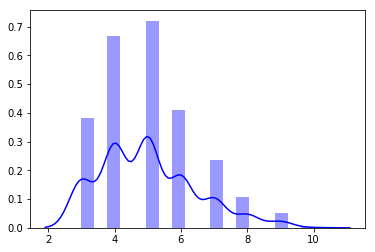

In [6]:
ids = df_train.iloc[:, [4]].values
counts = np.array([np.sum(ids == i) for i in range(int(np.max(ids)))])
sns.distplot(counts, color='b');

--> we can see that most containers have more than three messages

### lets check how much noise we receive compared to other labels

In [7]:
labels = df_train.iloc[:, [0]].values
df_train['LABEL'].describe()

count      4992
unique        4
top       NOISE
freq       1992
Name: LABEL, dtype: object

--> so we have 1000 containers which implies 3000 'true' messages and the rest (1992) is noise

### now let's build our predictor:
I wrote a simple class to implement a kNN Classifier that you can find in the knn.py file

In [8]:
# parameters
k = 25  # k is the number of neighbours taken into account
color_dic = {0: 'y', 1: 'r', 2: 'b', 3: 'g'}  # noise = 2

# get the data
labels = df_train.iloc[:, [0]].values
a = df_train.iloc[:, [1]].values
b = df_train.iloc[:, [2]].values

# scale the data (important so distances are not distorted)
sc_a = StandardScaler()
a = sc_a.fit_transform(a)
sc_b = StandardScaler()
b = sc_b.fit_transform(b)

# encode the labels
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
# noise = 2, unload_ship = 3, load_train = 1, depart_train = 0
# and events should occur in the order: unload, load, depart

# initiate classifier
clf = knnClassifier(labels, a, b, k)

/home/raph/.virtualenvs/ml/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/raph/.virtualenvs/ml/lib/python3.5/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### let's make a map of our predictions to see how this worked

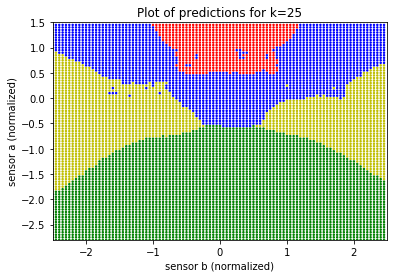

In [9]:
range_a = np.arange(-2.8, 1.5, 0.05)
range_b = np.arange(-2.5, 2.5, 0.05)

grid_a = np.zeros(len(range_a)*len(range_b))
grid_b = np.zeros(len(range_a)*len(range_b))

for i in range(len(range_a)):
    for j in range(len(range_b)):
        grid_a[i*len(range_b)+j] = range_a[i]
        grid_b[i*len(range_b)+j] = range_b[j]

grid_probs = clf.predict(grid_a, grid_b)
grid_prediction = np.argmax(grid_probs, axis=1)

grid_colors = [color_dic[u] for u in grid_prediction]
plt.scatter(grid_b, grid_a, s=2, c=grid_colors)
plt.axis([-2.5, 2.5, -2.8, 1.5])
plt.title("Plot of predictions for k="+str(k))
plt.xlabel("sensor b (normalized)")
plt.ylabel("sensor a (normalized)")
plt.show()

### now lets see our predictions on the training data

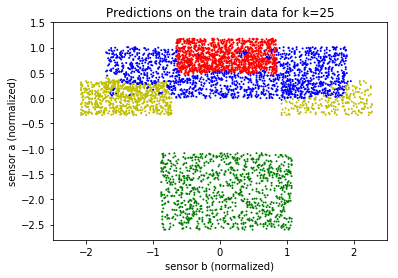

In [10]:
probs = clf.predict(a, b)
prediction = np.argmax(probs, axis=1)
colors = [color_dic[u] for u in prediction]
plt.scatter(b, a, s=1, c=colors)
plt.axis([-2.5, 2.5, -2.8, 1.5])
plt.title("Predictions on the train data for k="+str(k))
plt.xlabel("sensor b (normalized)")
plt.ylabel("sensor a (normalized)")
plt.show()

--> we can see that our predictor behaves differently in the two overlapping areas (that was the goal)

### and let's see how accurate we are on the training data:

In [11]:
print("accuracy: "+str(100*np.mean(prediction == labels))[:6]+"%")

accuracy: 84.595%


### This looks good, let's see how good the predictor is on the test data

In [12]:
df_test = pd.read_csv('test.csv')

test_labels = df_test.iloc[:, [0]].values
test_a = df_test.iloc[:, [1]].values
test_b = df_test.iloc[:, [2]].values
test_ids = df_test.iloc[:, [4]].values

test_a = sc_a.transform(test_a)
test_b = sc_b.transform(test_b)

test_labels = encoder.transform(test_labels)

test_probs = clf.predict(test_a, test_b)
test_prediction = np.argmax(test_probs, axis=1)
print("accuracy: "+str(100*np.mean(test_prediction == test_labels))[:6]+"%")

/home/raph/.virtualenvs/ml/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/raph/.virtualenvs/ml/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 84.458%


--> That's almost the same. The model doesn't look overfitted. That's encouraging but it is not good enough !
### Here is a function to predict the set of events that has the maximum likelihood
Explanation: we receive a set of signals $ S=(s_1,s_2,...,s_n) $. Thanks to the predictor we can transform S in $P=((p_{1,1},p_{1,2},p_{1,3},p_{1,4}), ..., (p_{n,1},p_{n,2},p_{n,3},p_{n,4}))$ where $p_{i,j}$={probability that the signal i is the event j}. (j can be 'load', 'unload', 'depart' or 'noise'). The function predict_event takes P in argument and returns the vector $E=(e_{1},...,e_{n})$ such as $ p_{1,e1} * ... * p_{n,en} $ is maximum. That is to say the sequence of event $(e_{1},...,e_{n})$ with the maximum likelihood. And we must have one and only one $e_{i}$ for each event in ('load', 'unload', 'depart').

In [13]:
def predict_event(probs):
    """
    :param probs: (numpy array) each row is an array of probabilities for each label
    (one line for one message)
    :return: (numpy array) the most likely sequence of events (encoded as 2=noise, 3=load,
    1=unload, 0=depart)
    """
    max_proba = 0.0
    max_mask = []
    nbr_events = len(probs[:, 0])
    for m in range(nbr_events-2):
        for n in range(1, nbr_events-1):
            for p in range(2, nbr_events):
                mask = [m, n, p]
                antimask = [i for i in range(nbr_events) if i not in mask]
                current_proba = 1.0
                current_proba *= probs[m, 3]
                current_proba *= probs[n, 1]
                current_proba *= probs[p, 0]

                for l in antimask:
                    current_proba *= probs[l, 2]
                if current_proba > max_proba:
                    max_proba = current_proba
                    max_mask = mask

    answer = np.ones(nbr_events, dtype=np.int64)*2
    answer[max_mask[0]] = 3
    answer[max_mask[1]] = 1
    answer[max_mask[2]] = 0

    return answer

### And now we are going to predict for each container the sequence of event with the maximum likelihood

In [14]:
for i in range(int(np.max(test_ids))):
    indexes = np.transpose(test_ids == i)[0]
    test_prediction[indexes] = predict_event(test_probs[indexes, :])

print("accuracy: "+str(100*np.mean(test_prediction == test_labels))[:6]+"%")

accuracy: 93.660%


--> That's much better.
### Earlier we said that the model would be hard to predict because of the overlaping areas. Let's check what are the predictions that we get wrong:

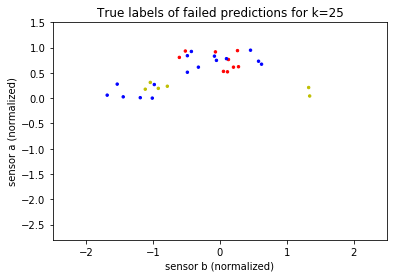

In [15]:
failed = test_prediction != test_labels
plt.scatter(test_b[failed], test_a[failed], c=[color_dic[u] for u in test_labels[failed]], s=6)
plt.axis([-2.5, 2.5, -2.8, 1.5])
plt.title("True labels of failed predictions for k="+str(k))
plt.xlabel("sensor b (normalized)")
plt.ylabel("sensor a (normalized)")
plt.show()

--> Indeed, the predictions that we get wrong are in the overlaping areas.
### Now we plot the influence of the 'k' parameter on the results

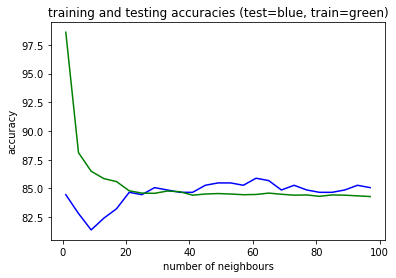

In [16]:
test_accuracies = []
train_accuracies = []
ks = range(1, 100, 4)
for i in ks:
    clf.k = i
    current_test_probs = clf.predict(test_a, test_b)
    current_test_prediction = np.argmax(current_test_probs, axis=1)
    test_accuracies.append(100*np.mean(current_test_prediction == test_labels))
    
    current_train_probs = clf.predict(a, b)
    current_train_prediction = np.argmax(current_train_probs, axis=1)
    train_accuracies.append(100*np.mean(current_train_prediction == labels))
    
plt.plot(ks, test_accuracies, c='b')
plt.plot(ks, train_accuracies, c='g')
plt.title("training and testing accuracies (test=blue, train=green)")
plt.xlabel("number of neighbours")
plt.ylabel("accuracy")
plt.show()

It appears that any value of k under 20 leads to a strong overfitting on the training set.

## Problem 2:
There is a lot of different ways to handle data that won't match up. Lets call our signal t. Lets say we received three different values for t. We will call them ti with t1 = 1, t2=2 and t3=10 (for now). We could say that a good prediction for t is the mean of the ti. This would lead to t=4.3. But if t3 is a 'lie' than we took into account the lie and we are mistaken, the real value might be 1 or 2 or 1.5.
    
We could also predict that t is the median of the values that are given to us. This would lead to t=2. This seems more reasonable. But we feel that we lack information on this subject. Lets say we have some examples of messages.
    

In [17]:
data = np.array([
    [1, 2, 3],
    [1, 5, 4],
    [1, 2],
    [1, 2, 3, 4, 3, 2],
    [1, 3, 5, 6]
])

So now we can learn the distribution of the distances between two points among a same set of data. And thanks to this we can say that we have an idea of how likely it is that two points are in the same set of data knowing the difference between them.

0.0357142857143


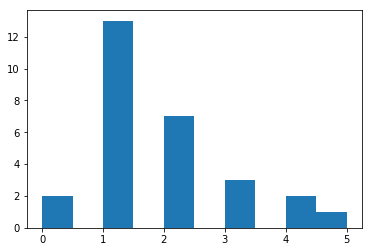

In [18]:
distances = []
for i in range(len(data)):
    for j in range(len(data[i])):
        for l in range(j+1, len(data[i])):
            distances.append(np.abs((data[i][j]-data[i][l])))
distances = np.array(distances)
plt.hist(distances);
# how many values are above 4.1
print(np.mean(distances>=4.1))

For instance we can see that only 3% of the distances are above 4.1. Let's say we have some intel on the data and that we know that if two values have a difference greater than 4, then one of the sources is probably lying. The model would then involve to choose the point ti such that [ti-D0, ti+D0] (here D0=4) is the interval with the greatest number of values tj inside this interval. Here is an illustration:

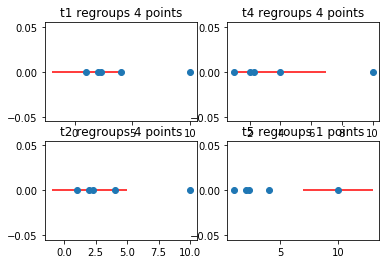

In [19]:
x = np.array([1, 2, 2.3, 4, 10])
y = np.zeros(len(x))
d0 = 3

def x_error(i):
    left = np.zeros(len(x))
    left[i] = d0
    return [left, left]

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=False)

ax = axs[0,0]
ax.errorbar(x, y, xerr = x_error(0), fmt='o', ecolor='r')
ax.set_title('t1 regroups 4 points')

ax = axs[1,0]
ax.errorbar(x, y, xerr = x_error(1), fmt='o', ecolor='r')
ax.set_title('t2 regroups 4 points')

ax = axs[0,1]
ax.errorbar(x, y, xerr = x_error(3), fmt='o', ecolor='r')
ax.set_title('t4 regroups 4 points')

ax = axs[1,1]
ax.errorbar(x, y, xerr = x_error(4), fmt='o', ecolor='r')
ax.set_title('t5 regroups 1 points');


So we look point by point how many other points fall inside the red line. The maximum number of values inside the red line is 4. We chose those four points and the rest is judged as not trustworthy. Once this is done we can choose a method to predict t among trustworthy data. We could use the mean or the median. We could also choose a distribution for those values such as N(mu, sigma). Then we can choose mu that maximises the likelihood of the data. (sigma is fixed and corresponds to the  standard deviation of the training dataset). So the prediction would be t0=mu.

So my answers would be:

- question one: My first approach would be too look for intel on the data. the intel can be quantitative or qualitative. (for instance, in this problem we know that it is not normal that the same event is reported by two sources with more than a few hours of difference). Another information coul be that usually 10% of the data is false. If I find such information, I can then eliminate messages that do not match up with the other messages.

- question two:
    - the RANSAC method is a method to eliminate incoherent values.
    - We could also imagine a model where the ti are distributed like a N(mu, sigma) around the true value t0. Then we could train mu and sigma on a training set where we know the value of t0. Once that we have estimated the values of mu and sigma, when we are given data t1, ..., tn we can look for the value of t0 that maximises the likelihood of the t1, ..., tn values.
    - We could also complexify the model by adding some reinforcement learning. Indeed, it is likely that some sources tend to be more trustworthy than others. So we could learn on the past. Sources start with a score that can increase or decrease depending on the distance of their values compared to the t0 value chosen. Then, when looking for t0, the score of the sources are taken into account for the optimization.

notes pour moi: Actually in the document, it looks like there is low number of values for a same event. So the reinforcment learning method, by giving a score to the different actors seems to be coherent for this.